# Импорт библиотек

In [183]:
import pandas as pd
import numpy as np


Загрузка данных

In [184]:
train_data = pd.read_excel('data/train.xlsx')
test_data = pd.read_excel('data/test.xlsx')


In [185]:
print('Train данные:')
print(train_data.head())
print(train_data.info())
print(train_data.describe())

Train данные:
          dt  Цена на арматуру
0 2015-01-05             32900
1 2015-01-12             32500
2 2015-01-19             32000
3 2015-01-26             30700
4 2015-02-02             30300
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
None
                        dt  Цена на арматуру
count                  400        400.000000
mean   2018-11-01 12:00:00      39229.475000
min    2015-01-05 00:00:00      21000.000000
25%    2016-12-03 06:00:00      31075.000000
50%    2018-11-01 12:00:00      35450.000000
75%    2020-09-29 18:00:00      42000.000000
max    2022-08-29 00:00:00      79000.000000
std                    NaN      13407.979668


In [186]:
print('Test данные:')
print(test_data.head())
print(test_data.info())
print(test_data.describe())

Test данные:
          dt  Цена на арматуру
0 2022-09-05             46000
1 2022-09-12             46000
2 2022-09-19             46000
3 2022-09-26             45500
4 2022-10-03             45500
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                28 non-null     datetime64[ns]
 1   Цена на арматуру  28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes
None
                        dt  Цена на арматуру
count                   28         28.000000
mean   2022-12-08 12:00:00      44250.000000
min    2022-09-05 00:00:00      40000.000000
25%    2022-10-22 06:00:00      41925.000000
50%    2022-12-08 12:00:00      42900.000000
75%    2023-01-24 18:00:00      45625.000000
max    2023-03-13 00:00:00      55500.000000
std                    NaN       3645.951585


In [187]:
def preprocess_data(df, is_train=True, target_col='Цена на арматуру'):
    """
    Полная предобработка данных с:
    - установкой даты как индекса
    - добавлением временных признаков
    - добавлением лагов
    - добавлением скользящих статистик (только для train)
    """
    # 1. Установка даты как индекса
    if 'dt' not in df.columns:
        raise ValueError("В данных отсутствует колонка 'dt'")
    
    df = df.copy()
    df['dt'] = pd.to_datetime(df['dt'])
    df.set_index('dt', inplace=True)
    
    # 2. Добавление временных признаков
    df['Год'] = df.index.year
    df['Месяц'] = df.index.month
    df['Неделя'] = df.index.isocalendar().week
    
    # 3. Добавление лагов
    lags = [1, 2, 3, 4, 8, 12]
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # 4. Скользящие статистики только для train
    if is_train:
        windows = [4, 8, 12]
        for window in windows:
            df[f'rolling_mean_{window}'] = df[target_col].rolling(window).mean()
            df[f'rolling_std_{window}'] = df[target_col].rolling(window).std()
            df[f'rolling_min_{window}'] = df[target_col].rolling(window).min()
            df[f'rolling_max_{window}'] = df[target_col].rolling(window).max()
    
    # Удаление строк с пропусками
    df = df.dropna()
    
    return df

# Обработка данных
train_data = preprocess_data(train_data, is_train=True)
test_data = preprocess_data(test_data, is_train=False)

# Выравнивание колонок (удаляем из train то, чего нет в test)
common_cols = list(set(train_data.columns) & set(test_data.columns))
train_data = train_data[common_cols]

In [188]:
print("Train данные:")
print(train_data.head())
print("\nTest данные:")
print(test_data.head())
print("\nОбщие колонки:", common_cols)

Train данные:
            Цена на арматуру   Год  Цена на арматуру_lag_1  Неделя  Месяц  \
dt                                                                          
2015-03-30             27200  2015                 27800.0      14      3   
2015-04-06             26600  2015                 27200.0      15      4   
2015-04-13             25700  2015                 26600.0      16      4   
2015-04-20             24800  2015                 25700.0      17      4   
2015-04-27             24700  2015                 24800.0      18      4   

            Цена на арматуру_lag_4  Цена на арматуру_lag_12  \
dt                                                            
2015-03-30                 29200.0                  32900.0   
2015-04-06                 29000.0                  32500.0   
2015-04-13                 28700.0                  32000.0   
2015-04-20                 27800.0                  30700.0   
2015-04-27                 27200.0                  30300.0   

    

In [189]:
print("\nПропуски в Train:", train_data.isnull().sum().sum())
print("Пропуски в Test:", test_data.isnull().sum().sum())


Пропуски в Train: 0
Пропуски в Test: 0


Анализ стационарности для train данных:


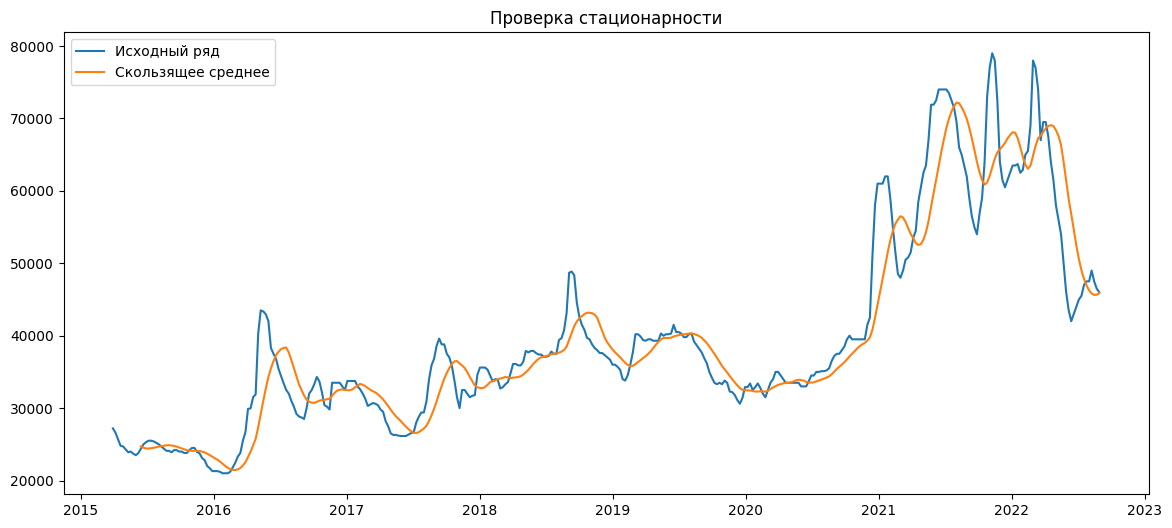

ADF Statistic: -2.0283907334718037
p-value: 0.2742651342734241
Critical Values:
	1%: -3.4475850438570115
	5%: -2.869135963767125
	10%: -2.5708164748773332

Ряд нестационарный - применяем дифференцирование


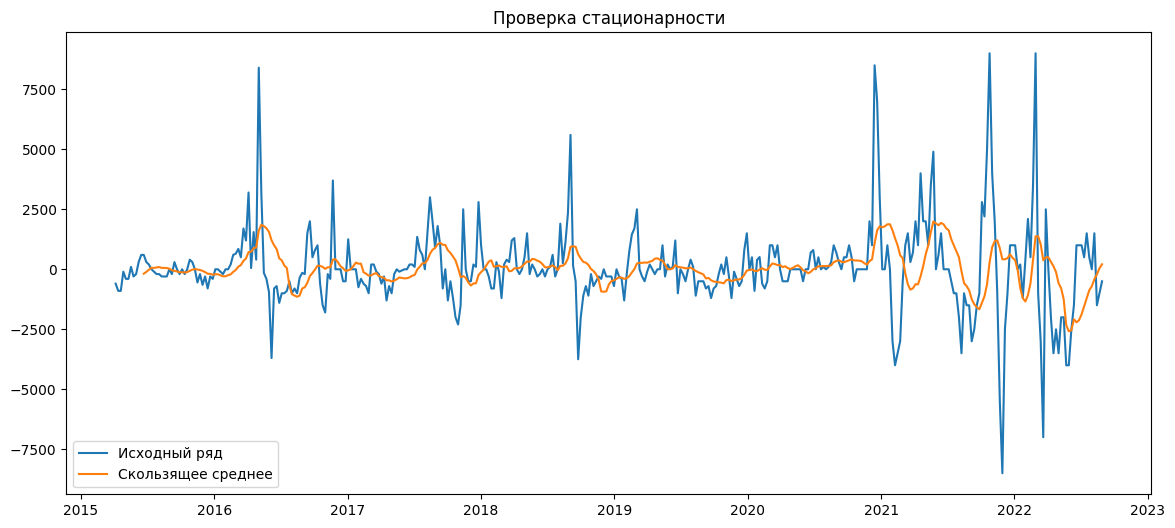

ADF Statistic: -8.625284996587874
p-value: 5.953288312105987e-14
Critical Values:
	1%: -3.4475850438570115
	5%: -2.869135963767125
	10%: -2.5708164748773332


In [190]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

target_col = 'Цена на арматуру'

def check_stationarity(series, window=12):
    """
    Проверка стационарности временного ряда с визуализацией
    """
    # Расчёт скользящей статистики
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    
    # Визуализация
    plt.figure(figsize=(14, 6))
    plt.plot(series, label='Исходный ряд')
    plt.plot(rolling_mean, label='Скользящее среднее')
    plt.legend()
    plt.title('Проверка стационарности')
    plt.show()
    
    # Тест Дики-Фуллера
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    return result[1] > 0.05  # Возвращает True если ряд нестационарный

# Проверяем train данные
print("Анализ стационарности для train данных:")
is_non_stationary = check_stationarity(train_data[target_col])

if is_non_stationary:
    print("\nРяд нестационарный - применяем дифференцирование")
    train_data['Цена_diff'] = train_data[target_col].diff().dropna()
    _ = check_stationarity(train_data['Цена_diff'].dropna())
else:
    print("\nРяд стационарный - преобразования не требуются")


Анализ автокорреляции:


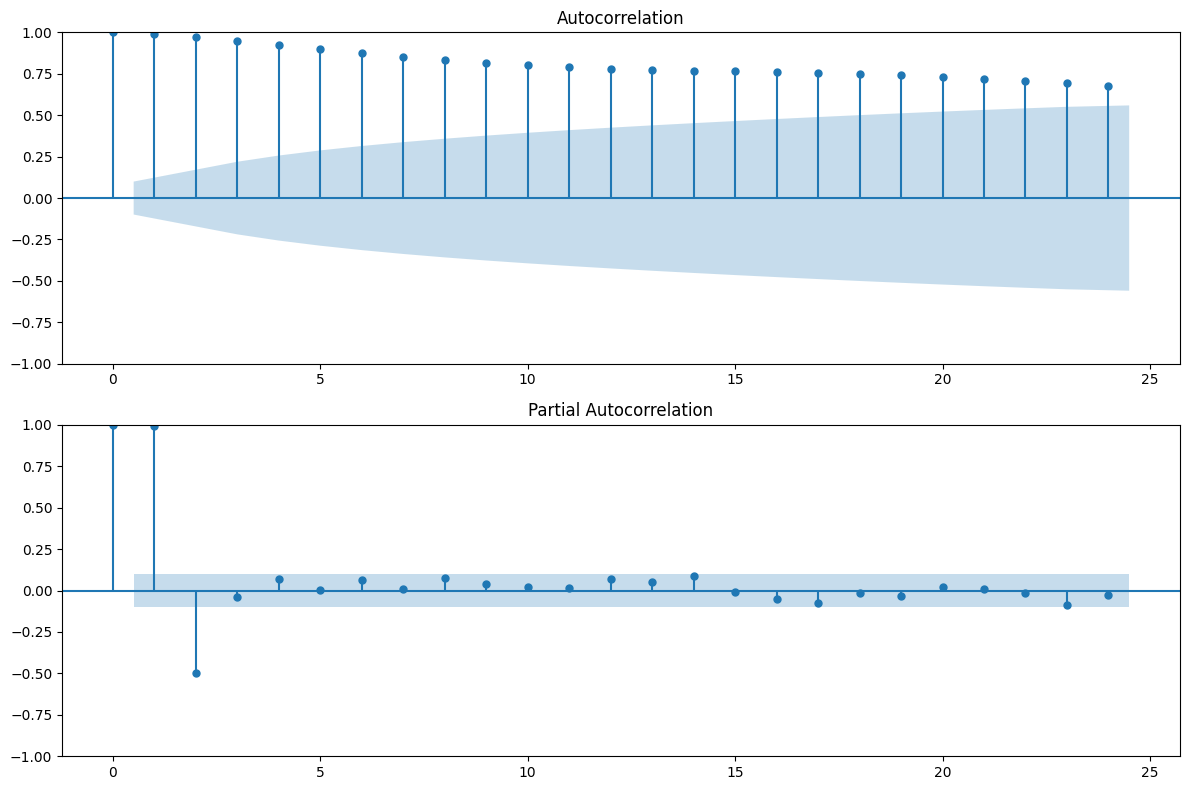

In [191]:
def plot_correlation(series, lags=24):
    """
    Построение графиков ACF и PACF
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series, lags=lags, ax=ax1)
    plot_pacf(series, lags=lags, ax=ax2)
    plt.tight_layout()
    plt.show()
target_col = 'Цена на арматуру'
print("\nАнализ автокорреляции:")
plot_correlation(train_data[target_col])

In [192]:
target_col = 'Цена на арматуру'  # Теперь переменная доступна во всем коде
X_train = train_data.drop(target_col, axis=1)
y_train = train_data[target_col]
X_test = test_data.drop(target_col, axis=1)

In [193]:
print(f"Train: {train_data.columns.tolist()}")
print(f"Test: {test_data.columns.tolist()}")

Train: ['Цена на арматуру', 'Год', 'Цена на арматуру_lag_1', 'Неделя', 'Месяц', 'Цена на арматуру_lag_4', 'Цена на арматуру_lag_12', 'Цена на арматуру_lag_2', 'Цена на арматуру_lag_3', 'Цена на арматуру_lag_8', 'Цена_diff']
Test: ['Цена на арматуру', 'Год', 'Месяц', 'Неделя', 'Цена на арматуру_lag_1', 'Цена на арматуру_lag_2', 'Цена на арматуру_lag_3', 'Цена на арматуру_lag_4', 'Цена на арматуру_lag_8', 'Цена на арматуру_lag_12']


In [194]:
# Удаляем скользящие средние из train, если их нет в test
cols_to_drop = [col for col in train_processed.columns 
                if 'rolling_' in col and col not in test_processed.columns]
train_final = train_processed.drop(columns=cols_to_drop)

In [195]:
# Для обучения
X_train = train_final.drop(['dt', 'Цена на арматуру'], axis=1)
y_train = train_final['Цена на арматуру']

# Для прогноза
X_test = test_processed.drop(['dt', 'Цена на арматуру'], axis=1)
dates_test = test_processed['dt']

In [197]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(1,0,1))  # (p,d,q) - d=0, так как ряд уже стационарен
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:       Цена на арматуру   No. Observations:                  396
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3453.670
Date:                Tue, 25 Mar 2025   AIC                           6915.339
Time:                        20:54:19   BIC                           6931.265
Sample:                             0   HQIC                          6921.649
                                - 396                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.93e+04   1.07e+04      3.675      0.000    1.83e+04    6.03e+04
ar.L1          0.9860      0.007    136.323      0.000       0.972       1.000
ma.L1          0.4426      0.027     16.467      0.0

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


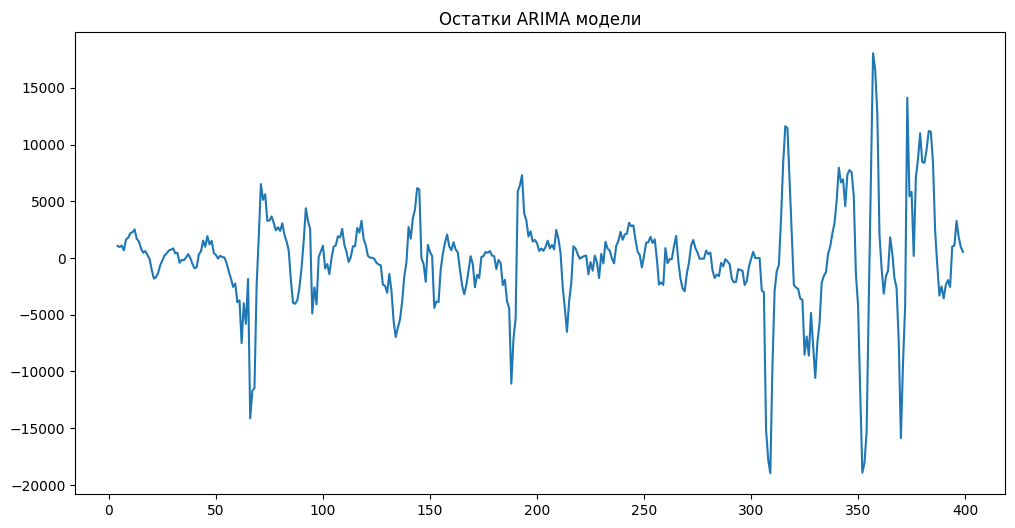

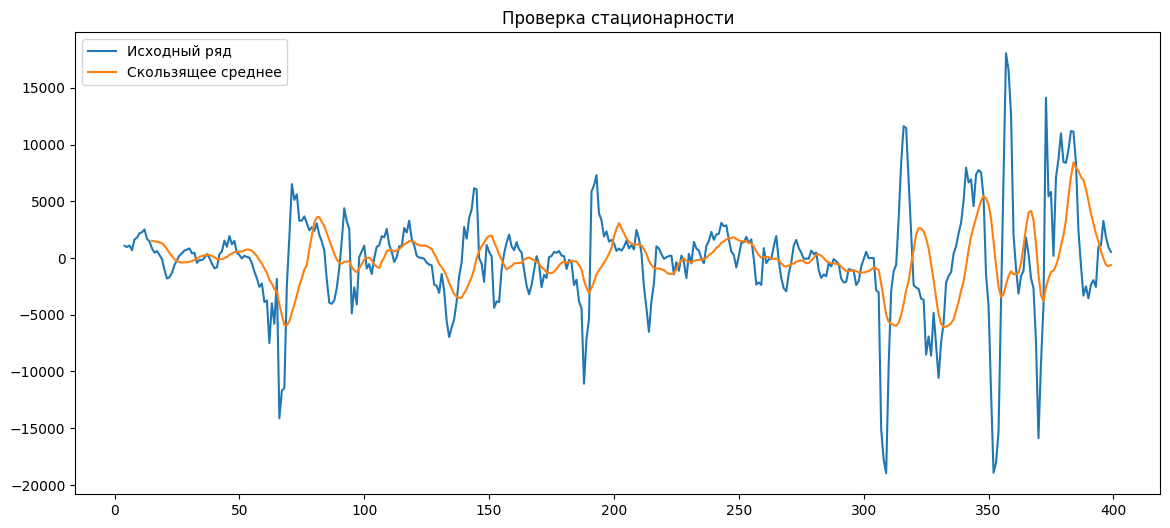

ADF Statistic: -5.5174830644600945
p-value: 1.9105051828451624e-06
Critical Values:
	1%: -3.4475850438570115
	5%: -2.869135963767125
	10%: -2.5708164748773332


False

In [201]:
# Правильное получение прогнозов для ARIMA
arima_pred = result.get_prediction(start=X_train.index[0], end=X_train.index[-1])
residuals = y_train - arima_pred.predicted_mean
forecast = result.get_forecast(steps=12)

# Визуализация остатков
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Остатки ARIMA модели')
plt.show()

# Тест на стационарность остатков
check_stationarity(residuals)

In [196]:
print("Ожидаемые признаки:", feature_columns)  #выводим ожидаемые моделью признаки и реальные колонки test_df для проверки их соответствия
print("Колонки test_df:", test_df.columns)

NameError: name 'feature_columns' is not defined

#Преобразование временных данных

In [ ]:
if "dt" in test_df.columns:
    test_df["dt"] = pd.to_datetime(test_df["dt"])
    test_df["year"] = test_df["dt"].dt.year
    test_df["month"] = test_df["dt"].dt.month
    test_df["day"] = test_df["dt"].dt.day
    test_df["week"] = test_df["dt"].dt.isocalendar().week

#Новые признаки на основе цены

In [ ]:
if "Цена на арматуру" in test_df.columns:
    test_df["Price_source"] = test_df["Цена на арматуру"].shift(1)  #цена на предыдущей неделе
    test_df["Price_Diff"] = test_df["Цена на арматуру"].diff()  #разница цены по сравнению с предыдущей неделей

    #заполняем NaN средними значениями соседних строк
    test_df["Price_source"] = test_df["Price_source"].interpolate(method="linear")
    test_df["Price_Diff"] = test_df["Price_Diff"].interpolate(method="linear")

    #если остались NaN, заменяем их средним значением
    test_df["Price_source"] = test_df["Price_source"].fillna(test_df["Price_source"].mean())
    test_df["Price_Diff"] = test_df["Price_Diff"].fillna(test_df["Price_Diff"].mean())

#Дополнительный вывод информации

In [ ]:
feature_columns = model.feature_names_in_
print("Ожидаемые признаки:", feature_columns)
print("Колонки test_df:", test_df.columns)

Ожидаемые признаки: ['year' 'month' 'day' 'week' 'Price_source' 'Price_Diff']
Колонки test_df: Index(['dt', 'Цена на арматуру', 'year', 'month', 'day', 'week',
       'Price_source', 'Price_Diff'],
      dtype='object')


#Подготовка данных для предсказания

In [ ]:
X_test = test_df[feature_columns]  #создаём новый датафрейм X_test, содержащий только те признаки, которые использовались при обучении модели 
test_df["Прогноз_цены"] = model.predict(X_test)

#Функция для расчёта количества недель закупки

In [ ]:
def calculate_weeks(row):
    if row["Прогноз_цены"] > row["Цена на арматуру"] * 1.02:  #если прогнозируемая цена вырастет более чем на 2% закупка на 6 недель (запас, чтобы избежать дорогих покупок в будущем)
        return 6
    elif row["Прогноз_цены"] > row["Цена на арматуру"]:  #если цена слегка повысится (но не выше 2%) закупка на 4 недели
        return 4
    elif row["Прогноз_цены"] < row["Цена на арматуру"] * 0.98:  #если цена снизится более чем на 2% → закупаем только на 1 неделю, чтобы позже купить дешевле.
        return 1
    else:
        return 3  #если цена остаётся стабильной → закупаем на 3 недели.
    
test_df["Закупка_на_колво_недель"] = test_df.apply(calculate_weeks, axis=1)  #применяеv функцию calculate_weeks к каждой строке датафрейма

In [ ]:
X_test = test_df[feature_columns]

In [ ]:
test_df["Прогноз_цены"] = model.predict(X_test).round().astype(int)  #предсказания цены на арматуру на следующую неделю, округление и приведение предсказания к целому числу
test_df = test_df.drop(columns=["Прогноз_недель"], errors="ignore")  #удаление прошлых косяков


In [ ]:
test_df.head()  #выводим первые 5 строк

,dt,Цена на арматуру,year,month,day,week,Price_source,Price_Diff,Прогноз_цены,Закупка_на_колво_недель
0,2022-09-05,46000,2022,9,5,36,43833.333333,351.851852,42795,1
1,2022-09-12,46000,2022,9,12,37,46000.000000,0.000000,46060,4
2,2022-09-19,46000,2022,9,19,38,46000.000000,0.000000,46132,4
3,2022-09-26,45500,2022,9,26,39,46000.000000,-500.000000,46645,6
4,2022-10-03,45500,2022,10,3,40,45500.000000,0.000000,44907,3


In [ ]:
test_df.to_excel("predicted_procurement.xlsx", index=False)  #сохраняем результат в формате xlsx

print("Прогнозирование завершено. Результаты сохранены в predicted_procurement.xlsx")

Прогнозирование завершено. Результаты сохранены в predicted_procurement.xlsx
